First, we try things out without transforming the mesh. We want to get rid of the Piola transformations. In the case of a non-transformed mesh this should not make a difference.

We solve the Helmholtz equation using a broken element ansatz, enforcing H(div)-continuity by introducing an additional trace space.

In [1]:
import matplotlib.pyplot as plt
from firedrake import *
import petsc4py.PETSc as PETSc
PETSc.Sys.popErrorHandler()

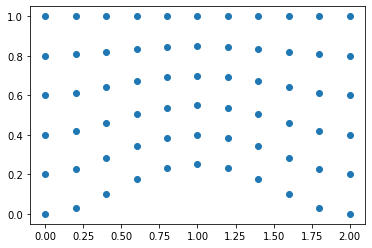

In [2]:
m = IntervalMesh(10,2)
mesh = ExtrudedMesh(m, 5, extrusion_type='uniform')

Vc = mesh.coordinates.function_space()
x, y = SpatialCoordinate(mesh)
f = Function(Vc).interpolate(as_vector([x, y + ( 0.25 * x**4 -x**3 + x**2) * (1-y) ] ) )
mesh.coordinates.assign(f)

xs = [mesh.coordinates.dat.data[i][0] for i in range(0,66)]
ys = [mesh.coordinates.dat.data[i][1] for i in range(0,66)]

plt.scatter(xs, ys)


In [3]:
element = FiniteElement("RTCF", cell="quadrilateral", degree=1)
element._mapping = 'identity'
Sigma = FunctionSpace(mesh, element)
V = FunctionSpace(mesh, "DG", 0)

W = Sigma * V

#############define problem ########################################################
sigma, u = TrialFunctions(W)
tau, v = TestFunctions(W)

#boundary conditions sigma dot n = 0 everywhere:
bc0 = DirichletBC(W.sub(0), as_vector([0.0, 0.0]), "bottom")
bc1 = DirichletBC(W.sub(0), as_vector([0.0, 0.0]), "top")
bc2 = DirichletBC(W.sub(0), as_vector([0.0, 0.0]), 1)
bc3 = DirichletBC(W.sub(0), as_vector([0.0, 0.0]), 2)

#force term
x, y = SpatialCoordinate(mesh)
f = 10*exp(-100*((x - 1)**2 + (y - 0.5)**2))

#set up variational problem
a = dot(sigma, tau)*dx  + div(tau)*u*dx + div(sigma)*v*dx + v*u*dx
L = -f*v*dx

#will be the solution
wh = Function(W)


In our implementation we solve subject to the BC $\sigma \cdot n = 0$:

### hybridized with HybridizationPC

In [4]:
hybrid_parameters = {'ksp_type': 'preonly',
                     'mat_type': 'matfree',
                     'pc_type': 'python',
                     'pc_python_type': 'firedrake.HybridizationPC',
                     # Solver for the trace system
                     'hybridization': {'ksp_type': 'gmres',
                                       'pc_type': 'gamg',
                                       'pc_gamg_sym_graph': True,
                                       'ksp_rtol': 1e-7,
                                       'mg_levels': {'ksp_type': 'richardson',
                                                     'ksp_max_it': 5,
                                                     'pc_type': 'bjacobi',
                                                     'sub_pc_type': 'ilu'}}}

In [5]:
problem = LinearVariationalProblem(a, L, wh, bcs=[bc0,bc1, bc2, bc3])

solver = LinearVariationalSolver(problem, solver_parameters=hybrid_parameters)

Text(0.5, 1.0, '$\\sigma$')

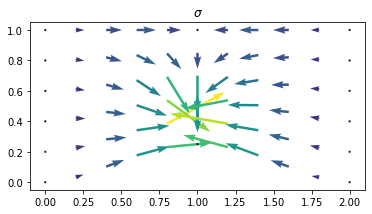

In [6]:
solver.solve()
sigmah, uh = wh.split()

#output/plot solution
file0 = File("IdentityHybridizationPC.pvd")
#can't write sigmah to file???
file0.write(sigmah,uh)
fig, axes = plt.subplots()
quiver(sigmah, axes=axes)
axes.set_aspect("equal")
axes.set_title("$\sigma$")
